## Анализ данных в задаче кредитного скоринга

#### Импорт билиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Для вывода всех колонок датафрейма
pd.set_option('max_columns', 30)

#### Чтение данных

In [3]:
df = pd.read_csv('Data/credit_card_default_analysis.csv')

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


### Проверка равентва медианных значений в двух группах

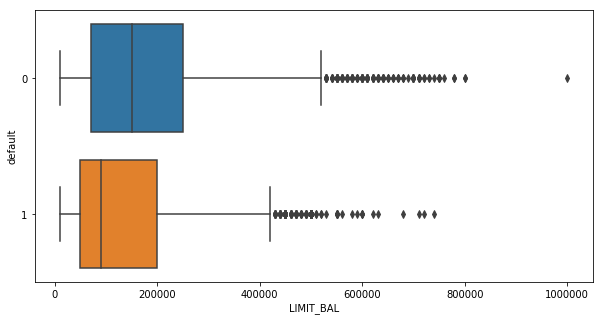

In [6]:
plt.figure(figsize=(10, 5))
sns.boxplot(df['LIMIT_BAL'], df['default'], orient='h')

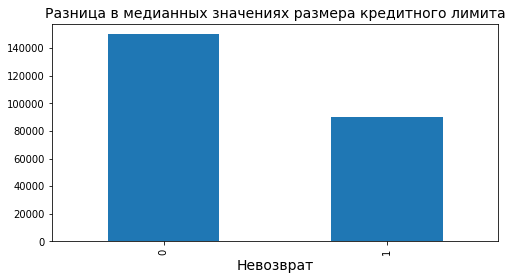

In [7]:
plt.figure(figsize=(8, 4))
df.groupby('default')['LIMIT_BAL'].median().plot(kind='bar');
plt.title('Разница в медианных значениях размера кредитного лимита', size=14);
plt.xlabel('Невозврат', size=14);

Из визуального анализа следует что сумма кредитного лимита у людей, вернувших кредит была выше, чем у людей, которые кредит не вернули. Проверим предположение с помощью статистики.

In [8]:
notdefault = df[df['default'] == 0]['LIMIT_BAL'].values
isdefault = df[df['default'] == 1]['LIMIT_BAL'].values

Проверим равенство медиан с помощью интервальной оценки, основанной на методе bootstrap

$H_0\colon$ медианные значения выборок равны

$H_1\colon$ медианы не равны

In [26]:
def get_bootstrap_samples(data, n_samples):
    """
    Ф-ция, генерирующая бутстреп выборки
    """
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [47]:
np.random.seed(9)

notdefault_median_scores = list(map(np.median, get_bootstrap_samples(notdefault, 10000)))
isdefault_median_scores = list(map(np.median, get_bootstrap_samples(isdefault, 10000)))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(notdefault_median_scores, isdefault_median_scores)))

In [50]:
print("95% доверительный интервал для разницы медиан",  stat_intervals(delta_median_scores, 0.05))

95% доверительный интервал для разницы медиан [-70000. -60000.]


Как видно из интервальной оценки разницы медиан, для людей, не вернувших кредиты, размер кредитного лимита был существенно меньше, чем для людей вернувщих кредит. Нулевая гипотеза отвергается. 

#### Проверка равенства средних для выборок